random forest virus & bacteria species table 
Choose a country
GROUP THE TRAIN/TEST SETS BY PATIENT

In [1]:
### load packages
import os
import os.path as path
import sys, os
import pandas as pd
import numpy as np
import math
import scipy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import re
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_auc_score
import random 

In [2]:
### location of this .ipynb
pathname =os.path.abspath("")
print (pathname)

### files
vir_table="../../intermediate_files/TGVG1.1_MPA4_combined_abundance.virus_species.wide.tsv"
bac_table="../../intermediate_files/TGVG1.1_MPA4_combined_abundance.bacteria_species.wide.tsv"
metadata_table="../../data/some_teddy_MP142_metadata2.all_samples1.delivery.csv"

/Users/u241374/mike_tisza/cmmr_repos/teddy_vir_bac_marker_gene/scripts/5_host_population_comparisons


In [3]:
### parse OTU files down to 1% prevalence, the combine

vir_df = pd.read_csv(pathname + "/" + vir_table, sep="\t", header=0, index_col=0)

thresh = math.ceil(len(vir_df.columns)/100)

persist_vir_df = vir_df[vir_df[vir_df > float(0.0)].count(axis=1) >= thresh]

bac_df = pd.read_csv(pathname + "/" + bac_table, sep="\t", header=0, index_col=0)

thresh = math.ceil(len(bac_df.columns)/100)

persist_bac_df = bac_df[bac_df[bac_df > float(0.0)].count(axis=1) >= thresh]

persist_comb_df = pd.concat([persist_vir_df, persist_bac_df])


persist_comb_df = persist_comb_df.T

del vir_df
del bac_df


In [4]:
### Choose a country here:
discrim_country = "USA"
#discrim_country = "Finland"
#discrim_country = "Germany"
#discrim_country = "Sweden"

metadata_df = pd.read_csv(pathname + "/" + metadata_table, header=0, index_col=False)
metadata_df.index = metadata_df.index.map(int)
metadata_df['brst_fed'] = metadata_df['brst_fed'].fillna(0)
metadata_df['sample'] = metadata_df['sample'].astype(str)

T1D = []
Country = []
IA = []
brst_fd = []
masks = []
for ind in persist_comb_df.index:
    state = metadata_df.loc[metadata_df['sample'] == ind, 'T1D'].values[0]
    country_q = metadata_df.loc[metadata_df['sample'] == ind, 'country'].values[0]
    ia1 = metadata_df.loc[metadata_df['sample'] == ind, 'IA'].values[0]
    milk = metadata_df.loc[metadata_df['sample'] == ind, 'brst_fed'].values[0]
    mid = metadata_df.loc[metadata_df['sample'] == ind, 'mask_id'].values[0]
    if milk == "":
        milk = 0
    brst_fd += [milk]
    Country += [country_q]
    T1D += [str(state)]
    IA += [str(ia1)]
    masks += [str(mid)]
#random.shuffle(T1D)
c_df = pd.DataFrame({'country': Country, 'T1D': T1D, 'IA': IA, 'breast_fed': brst_fd, 'mask_id': masks}, index=persist_comb_df.index)
### map({1: "USA", 2: "Finland", 3: "Germany", 4: "Sweden"})
if discrim_country == "USA" :
    c_df['country'] = c_df['country'].map({1: "USA", 2: "other", 3: "other", 4: "other"})
elif discrim_country == "Finland" :
    c_df['country'] = c_df['country'].map({1: "other", 2: "Finland", 3: "other", 4: "other"})
elif discrim_country == "Germany" :
    c_df['country'] = c_df['country'].map({1: "other", 2: "other", 3: "Germany", 4: "other"})
elif discrim_country == "Sweden" :
    c_df['country'] = c_df['country'].map({1: "other", 2: "other", 3: "other", 4: "Sweden"})


country_df = pd.concat([persist_comb_df, c_df], axis=1)

country_clean_df = country_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id'], axis=1)

In [5]:
### Don't change discrim_var
discrim_var = "country"
number_models = 50

mask_id_list = country_df['mask_id'].tolist()
unique_mask_list = []

for x in mask_id_list:
    # check if exists in unique_list or not
    if x not in unique_mask_list:
        unique_mask_list.append(x)

perc70 = math.ceil(len(unique_mask_list)*0.7)

train_mask_list = random.sample(unique_mask_list, perc70)

test_mask_list = list(set(unique_mask_list) - set(train_mask_list))

train_sample_df = country_df.loc[country_df['mask_id'].isin(train_mask_list)]
train_sample_clean_df = train_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id'], axis=1)
train_sample_list = list(train_sample_df[discrim_var])

test_sample_df = country_df.loc[country_df['mask_id'].isin(test_mask_list)]
test_sample_clean_df = test_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id'], axis=1)
test_sample_list = list(test_sample_df[discrim_var])

[0.9234867000061919, 0.9274808384266562, 0.8950963950453201, 0.90466297322253, 0.9078469947624411, 0.9061648544159981, 0.9064793289266468, 0.8956011629944399, 0.9058943604101173, 0.9156427451867807, 0.895876813986536, 0.9139253053091138, 0.923519101993809, 0.9097668385793689, 0.9321896304269823, 0.8878729994904485, 0.9012480831673046, 0.9326143282808653, 0.9274285880764713, 0.9225486302074802, 0.9292192126053741, 0.9117930797374755, 0.9258896854034053, 0.9112441467199268, 0.9213083686674676, 0.9159846695769026, 0.9443821714638683, 0.9222452854645521, 0.932306963657153, 0.9172925808942748, 0.9280922805805637, 0.9189611701811515, 0.9302623460444507, 0.9250293379601777, 0.9279905886598299, 0.9197716080100211, 0.8984295582736548, 0.9214056570492214, 0.9205982503486624, 0.9174881705553376, 0.9046857356966184, 0.9100834497007932, 0.8990146137521358, 0.906221144353604, 0.9186669006361043, 0.8986323322475845, 0.9246652339229625, 0.9050854381827289, 0.9134759815585961, 0.9126369005973844]


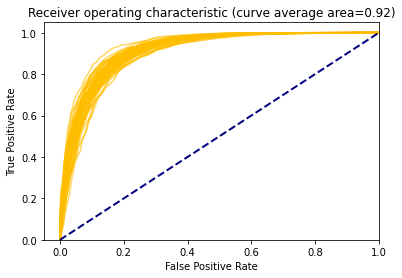

In [6]:
X=country_clean_df
y=list(country_df[discrim_var])

mask_id_list = country_df['mask_id'].tolist()
unique_mask_list = []

for x in mask_id_list:
    # check if exists in unique_list or not
    if x not in unique_mask_list:
        unique_mask_list.append(x)

perc70 = math.ceil(len(unique_mask_list)*0.7)

plt.figure()
ax = plt.gca()

#y = label_binarize(y, classes=[0, 1])
#print (X)

boot=range(int(number_models))
roc_series=[]
col = 0
import_df = pd.DataFrame(index = persist_comb_df.columns)
for q in boot:
	col += 1
	coln = "boot" + str(col)
	train_mask_list = random.sample(unique_mask_list, perc70)

	test_mask_list = list(set(unique_mask_list) - set(train_mask_list))

	train_sample_df = country_df.loc[country_df['mask_id'].isin(train_mask_list)]
	X_train = train_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id'], axis=1)
	y_train = list(train_sample_df[discrim_var])

	test_sample_df = country_df.loc[country_df['mask_id'].isin(test_mask_list)]
	X_test = test_sample_df.drop(['country', 'T1D', 'IA', 'breast_fed', 'mask_id'], axis=1)
	y_test = list(test_sample_df[discrim_var])
	random_state = np.random.RandomState(0)

	classifier = RandomForestClassifier(n_estimators=100, random_state=random_state)
	classifier.fit(X_train, y_train)
	#rfc_disp = plot_roc_curve(classifier, X_test, y_test, ax=ax, alpha=0.5, color='gold')
	rfc_disp = RocCurveDisplay.from_estimator(classifier, X_test, y_test, ax=ax, alpha=0.5, color='gold')

	rfc_disp.plot(ax=ax, alpha=0.2, color='darkorange')
	#roc_auc = auc(classifier)
	y_pred_proba = classifier.predict_proba(X_test)
	try:
		roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
	except ValueError:
		pass

	feature_imp = pd.Series(classifier.feature_importances_,index=persist_comb_df.columns, name=str(coln))
	feature_imp = feature_imp.to_frame()

	import_df = import_df.join(feature_imp)

	lw = 2
	roc_series += [roc_auc]

print (roc_series)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
ax.get_legend().remove()
roc_avg=np.average(roc_series)
#plt.legend(['ROC curve (area = %0.2f)' % roc_avg])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (curve average area=%0.2f)' % roc_avg)
plt.show()

In [10]:
ind_dir = pathname + "/" + "../../intermediate_files/random_forest_outputs/"

if os.path.isdir(ind_dir):
    print("Exists")
else:
    print("Doesn't exist")
    os.mkdir(ind_dir)

import_df["avg_importance"] = import_df.mean(axis = 1)

import_df = import_df.sort_values(by=['avg_importance'], ascending=False)

import_df["avg_importance"].to_csv(str(ind_dir) + "/rf_important_all_sp_" + str(discrim_country) + "_vs_not1_pat_groups.tsv", sep = "\t")

Exists


In [26]:
roc_df = pd.DataFrame({"Kingdom": "All", "Feature_type": "Country", "Variable" :str(discrim_country), "AUC": roc_series})


roc_df.to_csv(str(ind_dir) + "rf_ROC_AUC_all_sp_" + str(discrim_country) + "_vs_not1_pat_groups.tsv", sep = "\t", index = False)

In [27]:
os.system('say "your program has finished"')

0